# Demographics Impact on FordGoBikes Subscriptions

## Investigation Overview

In this investigation, I wanted to look at the demographics of FordGoBikes users that could be used to inform target audience for subscriptions. The main focus of this analysis was on gender, age, location, and days of the week rented.

## Dataset Overview

The data consisted of approxiamtely 174,952 (clean) entries all belonging to February of 2019. In total this set contains 16 features/columns (duration, start time, end time, start station id, start station name, start station latitude, start station longitude, end station id, end station name, end station latitude, end station longitude, bike id, user type, member birth year, member gender, bike share for all). There is a mix between numeric and categorical variables.

In [4]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import h3
from geopy.distance import geodesic

In [5]:
ford_data= pd.read_csv('201902-fordgobike-tripdata.csv')
df=ford_data.copy()

In [6]:
df.isnull().sum()

duration_sec                  0
start_time                    0
end_time                      0
start_station_id            197
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id              197
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                     0
member_birth_year          8265
member_gender              8265
bike_share_for_all_trip       0
dtype: int64

Considering that the sum of missing values is relatively small compared to our data set (183,412 rows), we will be dropping the rows with missing values.

In [7]:
df= df.dropna()

In [8]:
df.isnull().sum()

duration_sec               0
start_time                 0
end_time                   0
start_station_id           0
start_station_name         0
start_station_latitude     0
start_station_longitude    0
end_station_id             0
end_station_name           0
end_station_latitude       0
end_station_longitude      0
bike_id                    0
user_type                  0
member_birth_year          0
member_gender              0
bike_share_for_all_trip    0
dtype: int64

In [9]:
print(df.shape)
print(df.dtypes)

(174952, 16)
duration_sec                 int64
start_time                  object
end_time                    object
start_station_id           float64
start_station_name          object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name            object
end_station_latitude       float64
end_station_longitude      float64
bike_id                      int64
user_type                   object
member_birth_year          float64
member_gender               object
bike_share_for_all_trip     object
dtype: object


> Start and end time are an object rather than a DateTime object. 

> Birth year is a float, when it should be an int. 

> All id's (start/end station, bike) should are numerical when they should be strings/categorical.

In [10]:
df['start_time']= pd.to_datetime(df.start_time)
df['end_time']= pd.to_datetime(df.end_time)
df['member_birth_year']=df['member_birth_year'].astype('int')
df['start_station_id']=df['start_station_id'].astype('str')
df['end_station_id']=df['end_station_id'].astype('str')
df['bike_id']=df['bike_id'].astype('str')

In [11]:
df.dtypes

duration_sec                        int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id                   object
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                     object
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bike_id                            object
user_type                          object
member_birth_year                   int64
member_gender                      object
bike_share_for_all_trip            object
dtype: object

> Great! We have succesfully handled data types.

In [12]:
df.duplicated().sum()

0

In [13]:
df.describe()

,duration_sec,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,member_birth_year
count,174952.000000,174952.000000,174952.000000,174952.000000,174952.000000,174952.000000
mean,704.002744,37.771220,-122.351760,37.771414,-122.351335,1984.803135
std,1642.204905,0.100391,0.117732,0.100295,0.117294,10.118731
min,61.000000,37.317298,-122.453704,37.317298,-122.453704,1878.000000
25%,323.000000,37.770407,-122.411901,37.770407,-122.411647,1980.000000
50%,510.000000,37.780760,-122.398279,37.781010,-122.397437,1987.000000
75%,789.000000,37.797320,-122.283093,37.797673,-122.286533,1992.000000
max,84548.000000,37.880222,-121.874119,37.880222,-121.874119,2001.000000


### Structure of this dataset:
This set contains 174,952 entries all belonging to February of 2019. In total this set contains 16 features/columns (duration, start time, end time, start station id, start station name, start station latitude, start station longitude, end station id, end station name, end station latitude, end station longitude, bike id, user type, member birth year, member gender, bike share for all). There is a mix between numeric and categorical variables.

#### Main interest in this dataset:
The main features of interest I have for this dataset is finding which type of user is most likely to be renting FordGoBike's, as well as figuring out the general behaviors when renting a bike (usual duration, distance between stations) and how they relate to user type.

#### Features that will prove most useful:
The features of this data set I believe will prove to be the most useful for the purposes of my analysis are:
* **Longitude and latitude:** to assess distance between stations/distance traveled
* **Duration**: to understand how duration may relate to the general demographics of users if at all. 
* **Gender:** to understand if gender has an impact on duration/distance
* **Birth year:** to assess which generation is most likely to use FordGoBikes. 
* **Start and end time:** the time will help me understand whether weekdays/weekends bring more business and the time of the most active hours of the day.

In [14]:
df['age']= 2019-df['member_birth_year']
df.age.describe()

count    174952.000000
mean         34.196865
std          10.118731
min          18.000000
25%          27.000000
50%          32.000000
75%          39.000000
max         141.000000
Name: age, dtype: float64

In [15]:
show= df[df.age>=90].index
df=df.drop(show, axis=0)

In [16]:
df['duration_min']= df['duration_sec']/60
df.drop('duration_sec', axis=1, inplace=True)

In [17]:
#We take the start and end longitude and latitude to calculate the distance traveled from stations.
df['distance'] = df.apply((lambda row: geodesic((row['start_station_latitude'], row['start_station_longitude']),(row['end_station_latitude'], row['end_station_longitude'])).miles),axis=1)

In [18]:
df= df.drop(['start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude'], axis=1)
df.head()

,start_time,end_time,start_station_id,start_station_name,end_station_id,end_station_name,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,age,duration_min,distance
0,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21.0,Montgomery St BART Station (Market St at 2nd St),13.0,Commercial St at Montgomery St,4902,Customer,1984,Male,No,35,869.750000,0.338015
2,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86.0,Market St at Dolores St,3.0,Powell St BART Station (Market St at 4th St),5905,Customer,1972,Male,No,47,1030.900000,1.681051
3,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375.0,Grove St at Masonic Ave,70.0,Central Ave at Fell St,6638,Subscriber,1989,Other,No,30,608.166667,0.162113
4,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7.0,Frank H Ogawa Plaza,222.0,10th Ave at E 15th St,4898,Subscriber,1974,Male,Yes,45,26.416667,1.498758
5,2019-02-28 23:49:58.632,2019-03-01 00:19:51.760,93.0,4th St at Mission Bay Blvd S,323.0,Broadway at Kearny,5200,Subscriber,1959,Male,No,60,29.883333,2.068083


In [19]:
df['hour'] = df['start_time'].apply(lambda time: time.hour)

In [20]:
males= df.query('member_gender == "Male"')
females= df.query('member_gender == "Female"')
other= df.query('member_gender == "Other"')

### Distribution of users based on gender:
The majority of FordGoUsers are males, making up for nearly 75% of total users. Females make up for 23.3% and other genders for 2.1%. This data is visualized in a pie chart below.


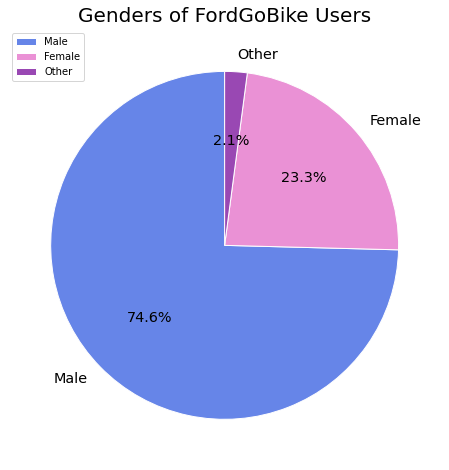

In [35]:
gender=df.member_gender.value_counts()
colors=['#6685E8','#EA91D5','#9948B3']
labels= ['Male','Female','Other']
plt.figure(figsize=(8,8))
plt.title('Genders of FordGoBike Users', fontsize=20)
plt.pie(gender,labels=labels, autopct='%1.1f%%',wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'},textprops={'size': 'x-large'}, colors= colors,startangle=90);
plt.legend(['Male','Female','Other'])
plt.show()

### Distribution of users based on age:
The majority of FordGoBike's users fall in the range of 25-35 years old followed by people in their mid30s and 40s. Users above 55 years old are rare, and the second least common group are those aged 18-24. This is visualized with a distribution plot below.

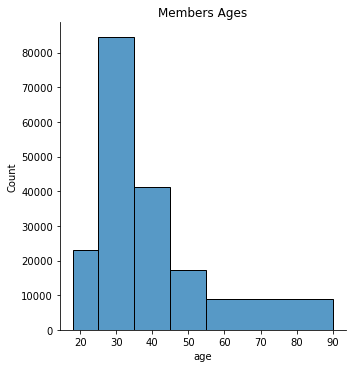

In [36]:
bins=[18,25,35,45,55,90]
labels= ['18-25','26-35','36-45','46-55','56+']
sb.displot(df['age'], bins=bins).set(title='Members Ages');

### Weekdays V. Weekends

In [23]:
df["day_start"] = df["start_time"].dt.weekday
df["day_end"]= df["end_time"].dt.weekday

In [24]:
days = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
df['day_start'] = df['day_start'].map(days)
df['day_end'] = df['day_end'].map(days)

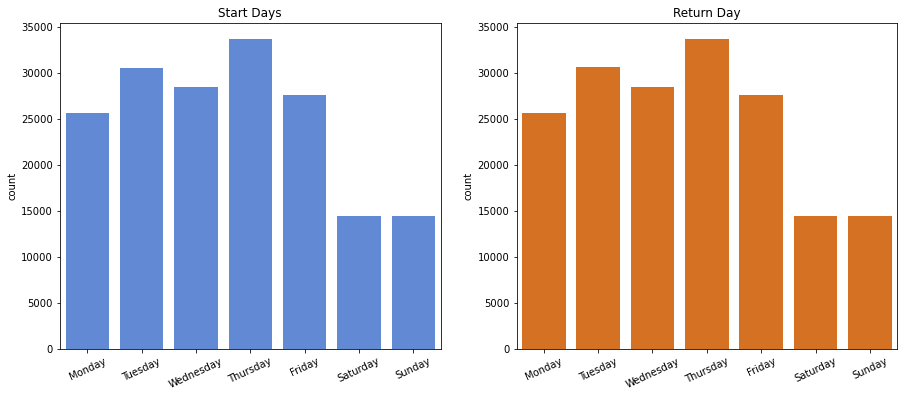

In [25]:
orders= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
sb.countplot(data=df, x='day_start',order=orders, color='#4F83E6').set(title='Start Days', xlabel='');
plt.xticks(rotation=25)
plt.subplot(1,2,2)
sb.countplot(data=df, x='day_end',order=orders, color='#F36D04').set(title='Return Day', xlabel='');
plt.xticks(rotation=25)
plt.show()

> As we can see, the most common day to rent and return a bike in February of 2019 was Thursday followed by Tuesday. As we can see the plots for both start and return day are pretty much identical. 

### Distribution of users based on subscription and gender:
9.5% of FordGoBike users in February of 2019 were subscribers. 75% of subscribers were male, followed by a 22.8% females and 2% for other genders. This distribution is nearly identical to that of the overall users. 

In [26]:
pop_stations_start= df.query('start_station_id== "58.0"|start_station_id== "67.0"|start_station_id== "81.0"|start_station_id== "21.0"|start_station_id== "3.0"')
pop_stations_end=df.query('end_station_id== "58.0"|end_station_id== "67.0"|end_station_id== "21.0"|end_station_id== "30.0"|end_station_id== "15.0"')

### User type:

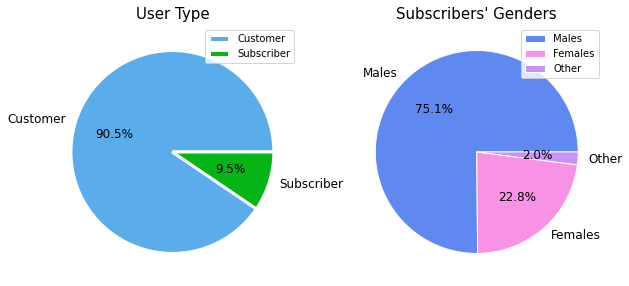

In [40]:
plt.figure(figsize=[10,8])
plt.subplot(1,2,1)
plt.pie(df['user_type'].value_counts(), labels=['Customer','Subscriber'],autopct='%1.1f%%',
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},textprops={'size': 'large'},colors=['#5AADEA','#06B416']);
plt.title('User Type', fontsize=15);
plt.legend(['Customer', 'Subscriber'])
plt.subplot(1,2,2)
subscribers= df.query('user_type=="Subscriber"')
gender = subscribers.member_gender.value_counts()
colors=['#5F89F1','#F892E5','#C892F8']
labels= ['Males','Females','Other']
plt.pie(gender, labels=labels,autopct='%1.1f%%',wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'},textprops={'size': 'large'},colors=colors);
plt.title("Subscribers' Genders", fontsize=15)
plt.legend(['Males','Females','Other'])
plt.show()

As expected given the demographics observed in this dataset, the majority of subscribers are Males. 

### Most popular stations and their user type:
The most popular stations overall saw an overwhelming majority of subscribers over casual users for both start and return station.

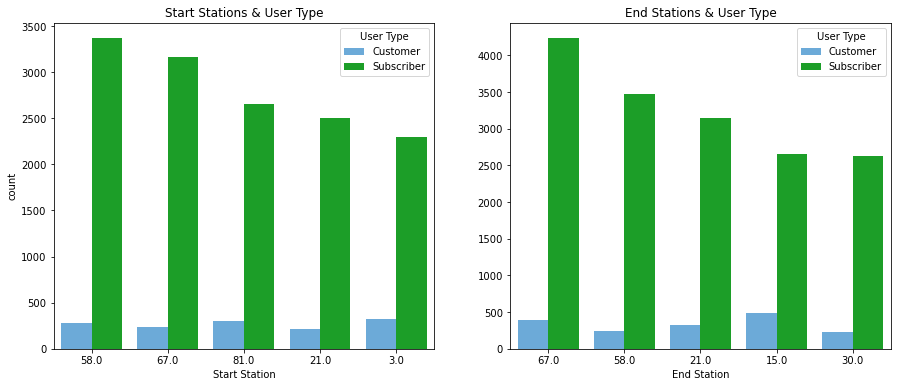

In [29]:
order_s= ['58.0','67.0','81.0','21.0','3.0']
order_e=['67.0','58.0','21.0','15.0','30.0']
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
sb.countplot(data=pop_stations_start,x='start_station_id', hue='user_type', order=order_s,palette=['#5AADEA','#06B416'])
plt.legend(title='User Type')
plt.xlabel('Start Station')
plt.title('Start Stations & User Type')
plt.subplot(1,2,2)
sb.countplot(data=pop_stations_end,x='end_station_id', hue='user_type',order=order_e, palette=['#5AADEA','#06B416'])
plt.legend(title='User Type')
plt.xlabel('End Station')
plt.title('End Stations & User Type')
plt.ylabel('')
plt.show()

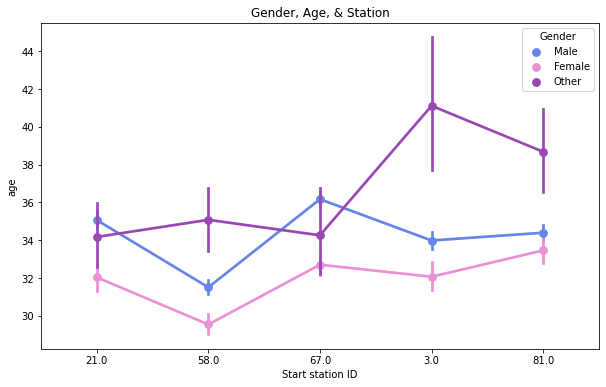

In [30]:
plt.figure(figsize=[10,6])
sb.pointplot(data=pop_stations_start, x='start_station_id', y='age', hue='member_gender', palette=['#6685E8','#EA91D5','#9948B3']).set(title='Gender, Age, & Station', xlabel='Start station ID');
plt.legend(title='Gender')
plt.show()

>Wow! Interestingly although they make up for only 9.5% of users, subscribers are the ones who most frequently rent and return in the popular stations.

### Weekdays and time influence on rentals:
Most bikes are rented on Thursday mornings. Overall, the most popular time to rent FordGoBikes was between 8-10 AM followed by 4-6 PM as shown in the heatmap below.  

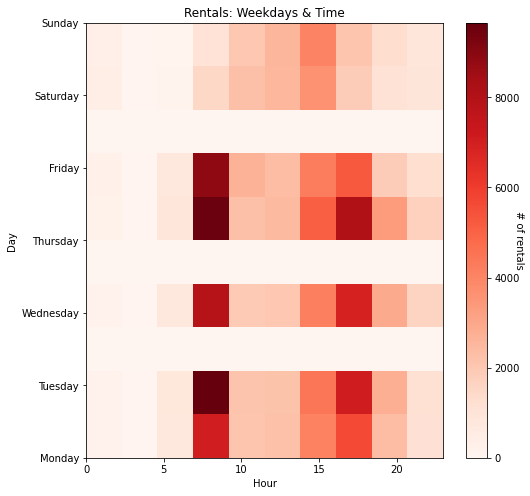

In [31]:
day_num=df["start_time"].dt.weekday
y_labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.figure(figsize=[8,8])
plt.hist2d(df['hour'],day_num,cmap=plt.cm.Reds)
plt.yticks([0,1,2,3,4,5,6], labels=y_labels)
cbar=plt.colorbar()
cbar.set_label('# of rentals', rotation=270)
plt.xlabel('Hour')
plt.ylabel('Day')
plt.title('Rentals: Weekdays & Time')
plt.show()

### Distribution based on duration, gender, and weekday:
Overall, males tend to use bikes for a shorter period of time than females and other genders with an average of <15 minutes. Other genders tend to have the highest duration, usually over 15 minutes. While weekends are not the most popular time to rent, they are the days in which all genders tend to bike for longer.

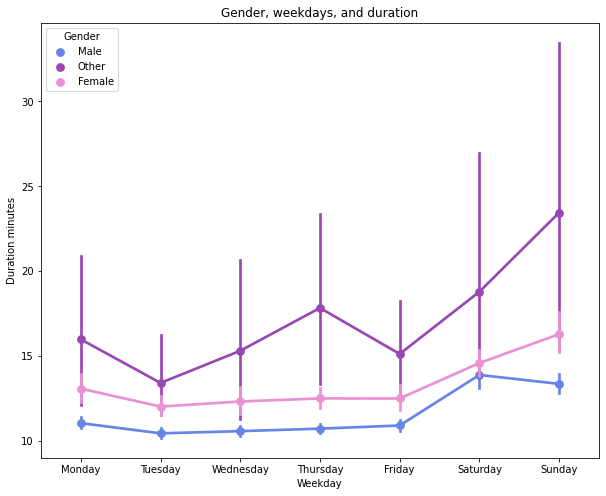

In [32]:
days_labels= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
order_d= days_labels
plt.figure(figsize=[10, 8])
sb.pointplot(data = df, x = 'day_start', y = 'duration_min', hue = 'member_gender',palette=['#6685E8','#9948B3','#EA91D5'], order=order_d).set(title='Gender, weekdays, and duration', xlabel='Weekday', ylabel='Duration minutes')
plt.legend(title='Gender')
plt.xticks(np.arange(0, 6 + 1, 1),days_labels)
plt.show()

## Stations age/gender/station

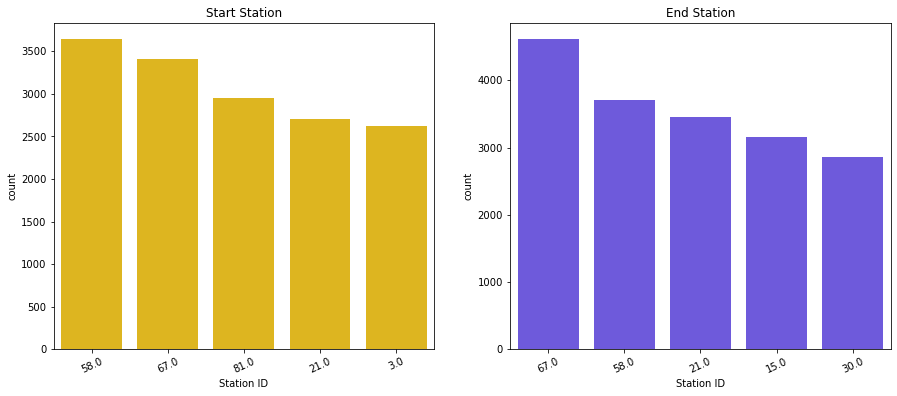

In [33]:
order_s= ['58.0','67.0','81.0','21.0','3.0']
order_e=['67.0','58.0','21.0','15.0','30.0']
labels_start= ['58.0, Market St at 10th St','67.0 San Francisco Caltrain Station 2','81.0, Berry St at 4th St','21.0, Montgomery St BART Station','3.0, Powell St BART Station']
labeles_end= ['67.0, San Francisco Caltrain Station 2','58.0, Market St at 10th St','21.0, Montgomery St BART Station','15.0, San Francisco Ferry Building', '30.0, San Francisco Caltrain']
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
sb.countplot(data=pop_stations_start,x='start_station_id', order=order_s,color='#FCC700').set(title='Start Station',xlabel='Station ID')
plt.xticks(rotation=25)
plt.subplot(1,2,2)
sb.countplot(data=pop_stations_end,x='end_station_id',order=order_e, color='#5F45F0').set(title='End Station',xlabel='Station ID')
plt.xticks(rotation=25)
plt.show()

As we can see, the stations *58.0, 67.0, and 21.0* are amongst the most popular stations to rent and return. How is this relevant? Knowing how frequented each station is helps us determine how bikes should be distributed across the city.

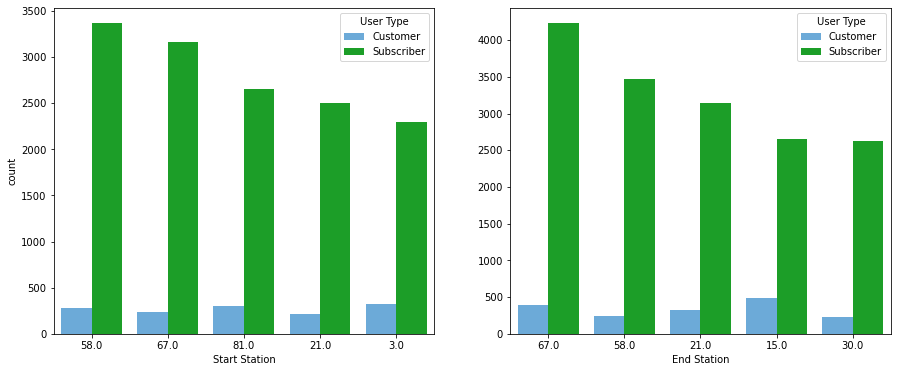

In [34]:
order_s= ['58.0','67.0','81.0','21.0','3.0']
order_e=['67.0','58.0','21.0','15.0','30.0']
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
sb.countplot(data=pop_stations_start,x='start_station_id', hue='user_type', order=order_s,palette=['#5AADEA','#06B416'])
plt.legend(title='User Type')
plt.xlabel('Start Station')
plt.subplot(1,2,2)
sb.countplot(data=pop_stations_end,x='end_station_id', hue='user_type',order=order_e, palette=['#5AADEA','#06B416'])
plt.legend(title='User Type')
plt.xlabel('End Station')
plt.ylabel('')
plt.show()